# Prediction the passengers count on a Ship

## Import the necessary libraries and read the dataset

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv('SeaPlaneTravel.csv')

In [5]:
data.head()

,Month,#Passengers
0,2004-01,112
1,2004-02,118
2,2004-03,132
3,2004-04,129
4,2004-05,121


In [6]:
data.rename(columns={'#Passengers': 'Count'}, inplace=True)

## Make sure that the 'Month' column is set as index and it should only be in DateTime format

In [7]:
data = data.set_index('Month')

In [8]:
data.index = pd.to_datetime(data.index, infer_datetime_format=True)

In [9]:
data.head()

,Count
Month,
2004-01-01,112
2004-02-01,118
2004-03-01,132
2004-04-01,129
2004-05-01,121


## Resample the data to monthly frequency

In [10]:
data = data.resample('M').mean()

In [11]:
data.index

DatetimeIndex(['2004-01-31', '2004-02-29', '2004-03-31', '2004-04-30',
               '2004-05-31', '2004-06-30', '2004-07-31', '2004-08-31',
               '2004-09-30', '2004-10-31',
               ...
               '2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30',
               '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
               '2015-11-30', '2015-12-31'],
              dtype='datetime64[ns]', name='Month', length=144, freq='M')

## Visualize the data

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
sns.set()

## Checking for Stationary

In [20]:
font_dict = {
    'weight': 'bold',
    'size': 18
}

Text(0.5, 1.0, 'Increase in Passenger Count')

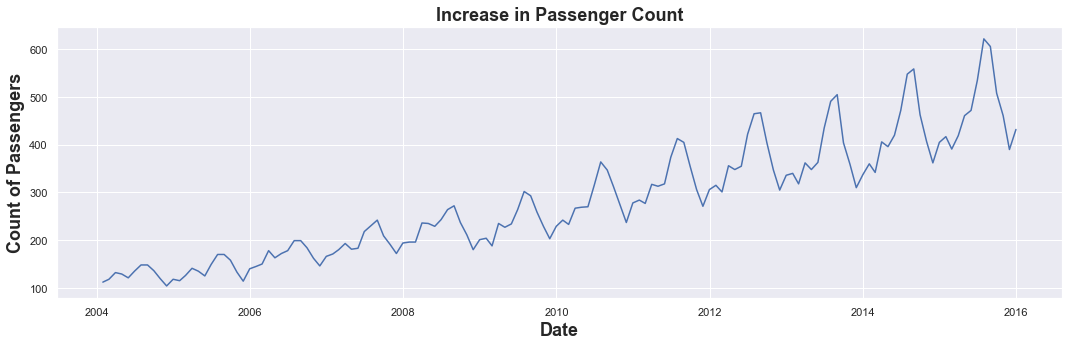

In [23]:
plt.figure(figsize=(18, 5))
plt.plot(data.Count)
plt.xlabel('Date', fontdict=font_dict)
plt.ylabel('Count of Passengers', fontdict=font_dict)
plt.title('Increase in Passenger Count', fontdict=font_dict)

#### Make data stationary, that is mean or avg =0 only then we can predict

## Observations - 
Data is not sationary, convert it to stationary data by differencing. Differencing means to subtract the value of 'Passenger Count' from the value of yesterday's passenger count. This technique is used so that the data should have 0 mean.

In [25]:
differenced_data = data.Count - data.Count.shift()
differenced_data.head()

Month
2004-01-31     NaN
2004-02-29     6.0
2004-03-31    14.0
2004-04-30    -3.0
2004-05-31    -8.0
Freq: M, Name: Count, dtype: float64

Text(0.5, 1.0, 'Differenced Data-Level-1')

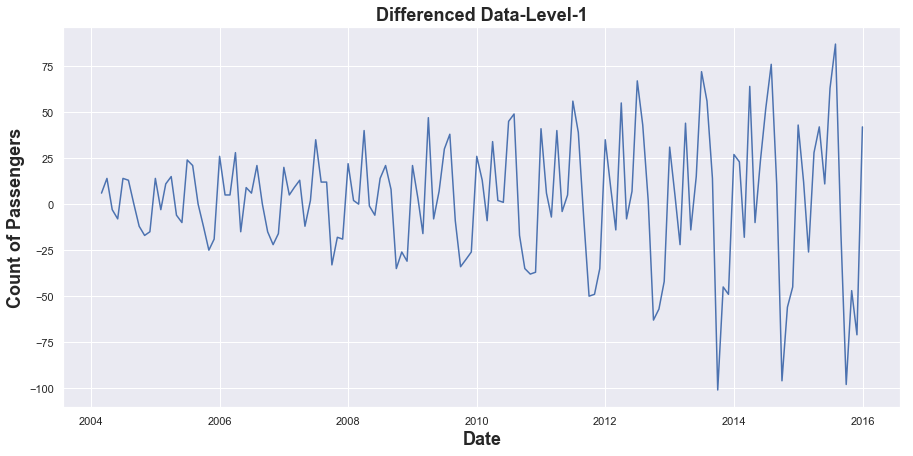

In [30]:
plt.figure(figsize=(15, 7))
plt.plot(differenced_data)
plt.xlabel('Date', fontdict=font_dict)
plt.ylabel('Count of Passengers', fontdict=font_dict)
plt.title('Differenced Data-Level-1', fontdict=font_dict)

## Checking for Mean and Standard Deviation

In [32]:
rolling_mean = differenced_data.rolling(12).mean()
rolling_std = differenced_data.rolling(12).std()

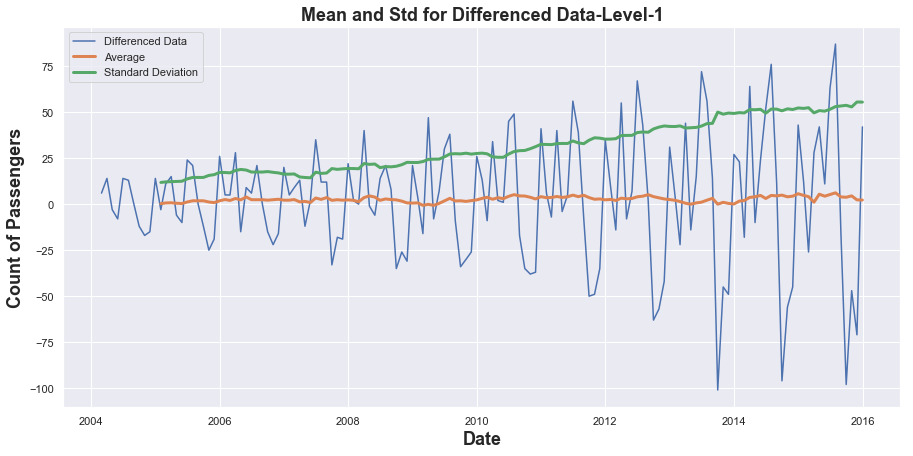

In [35]:
plt.figure(figsize=(15, 7))
plt.plot(differenced_data, label='Differenced Data')
plt.plot(rolling_mean, label='Average', linewidth=3)
plt.plot(rolling_std, label='Standard Deviation', linewidth=3)
plt.xlabel('Date', fontdict=font_dict)
plt.ylabel('Count of Passengers', fontdict=font_dict)
plt.title('Mean and Std for Differenced Data-Level-1', fontdict=font_dict)
plt.legend()

## Checking the value for ACF, PACF graph

#### AutoRegressive value (p) - 
AutoRegressive model uses the past value to predict the future value. E.g. we can say that next days' value will depend upon the previous 1 or 2 days.

#### Moving Average value (q) - 
Moving Average does not take into account the past value but it uses the error from the past forecasts, to predict the future value.

In [36]:
from statsmodels.tsa.stattools import acf, pacf

In [37]:
differenced_data.dropna(inplace=True)

In [55]:
lag_acf = pd.Series(acf(differenced_data, nlags=10))
lag_pacf = pd.Series(pacf(differenced_data, nlags=10, method='ols'))

Text(0.5, 1.0, 'Auto Correlation value (p)')

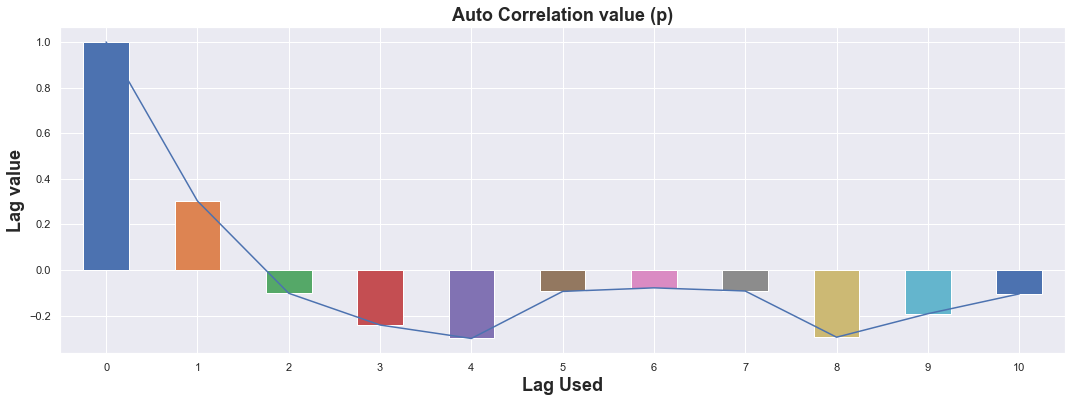

In [64]:
plt.figure(figsize=(18, 6))
lag_acf.plot(kind='bar') ## used to visualize the bar graph
lag_acf.plot() ## used to visualize the line graph
plt.xlabel('Lag Used', fontdict=font_dict)
plt.ylabel('Lag value', fontdict=font_dict)
plt.title('Auto Correlation value (p)', fontdict=font_dict)

Text(0.5, 1.0, 'Partial Auto Correlation value (q)')

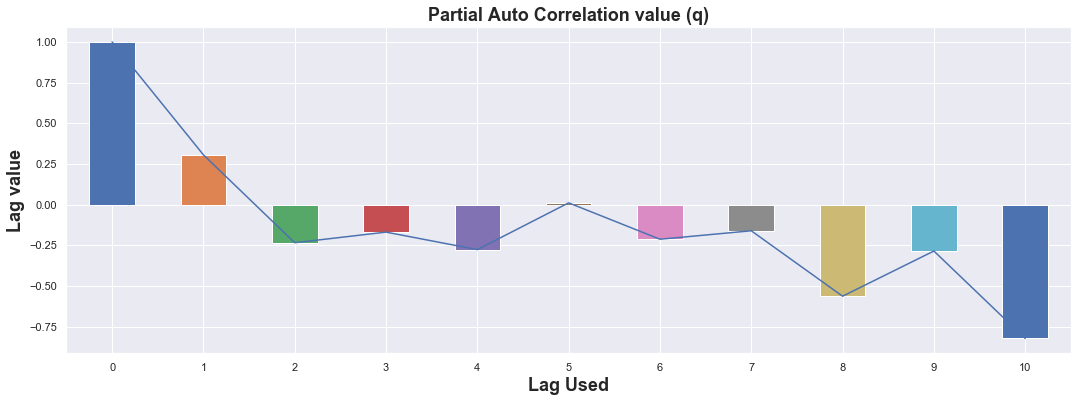

In [66]:
plt.figure(figsize=(18, 6))
lag_pacf.plot.bar() ## used to visualize lag number used
lag_pacf.plot() ## used to visualize lag value
plt.xlabel('Lag Used', fontdict=font_dict)
plt.ylabel('Lag value', fontdict=font_dict)
plt.title('Partial Auto Correlation value (q)', fontdict=font_dict)

## Observations - 
1. Differencing (d) - 1
2. AR (p) - 2
3. MA (q) - 2

#### Note - 
1. If the stationarised series has positive auto correlation at Lag-1, AR model is good.
2. If the stationarised series has negative auto correlation at Lag-1, MA model is good.

## Performing ARIMA Forecast

In [67]:
history = []

In [68]:
from statsmodels.tsa.arima_model import ARIMA

In [69]:
size = int(len(data.Count) * 0.66)
train, test = data.Count[0:size], data.Count[size:len(data.Count)]
history = [x for x in train]
predictions = list()

In [70]:
train.head()

Month
2004-01-31    112
2004-02-29    118
2004-03-31    132
2004-04-30    129
2004-05-31    121
Freq: M, Name: Count, dtype: int64

In [71]:
test.head()

Month
2011-12-31    306
2012-01-31    315
2012-02-29    301
2012-03-31    356
2012-04-30    348
Freq: M, Name: Count, dtype: int64

In [72]:
history[:5]

[112, 118, 132, 129, 121]

In [73]:
import warnings

In [74]:
warnings.filterwarnings('ignore')

In [75]:
for t in range(len(test)):
#     if (t==7):
#         break
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))

## Visualize the forecast and observed values

In [76]:
observed_values = pd.Series(history, index=data.index)

In [77]:
observed_values.head()

Month
2004-01-31    112
2004-02-29    118
2004-03-31    132
2004-04-30    129
2004-05-31    121
Freq: M, dtype: int64

In [78]:
prediction_values = pd.Series(predictions, index=test.index)

In [79]:
prediction_values.head()

Month
2011-12-31    273.193011
2012-01-31    323.309748
2012-02-29    343.625393
2012-03-31    312.742956
2012-04-30    369.700426
Freq: M, dtype: float64

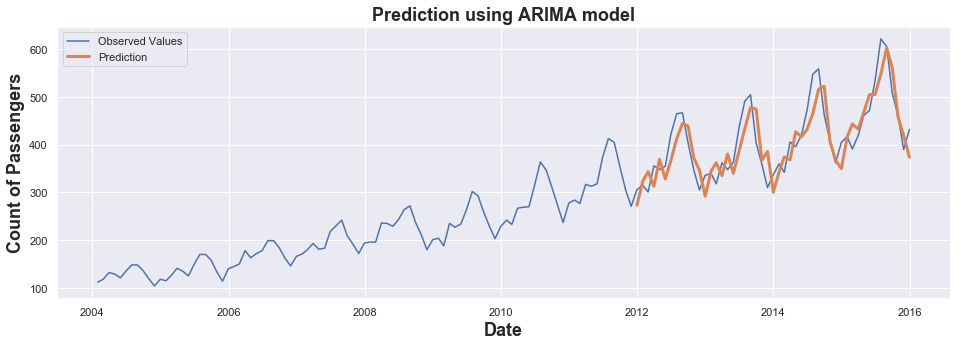

In [81]:
plt.figure(figsize=(16, 5))
plt.plot(observed_values, label='Observed Values')
plt.plot(prediction_values, label='Prediction', linewidth=3)
plt.xlabel('Date', fontdict=font_dict)
plt.ylabel('Count of Passengers', fontdict=font_dict)
plt.title('Prediction using ARIMA model', fontdict=font_dict)
plt.legend()

## Checking Errors

In [82]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [83]:
error = sqrt(mean_squared_error(test, predictions))
error

40.09381000509181

## Making predictions for next 1 year

In [84]:
from pandas import datetime

In [85]:
start_index = datetime(2016, 1, 31)
end_index = datetime(2016, 12, 31)

In [86]:
value = model_fit.forecast(steps=12)[0]

In [87]:
prediction_one_year = pd.Series(value)

In [88]:
month_generator = [x for x in range(1, 13)]

In [89]:
next_year = []

In [90]:
def date_generator():
    for i in month_generator:
        date = datetime(2016, i, 1)
        next_year.append(date)

In [91]:
date_generator()

In [92]:
next_year

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 2, 1, 0, 0),
 datetime.datetime(2016, 3, 1, 0, 0),
 datetime.datetime(2016, 4, 1, 0, 0),
 datetime.datetime(2016, 5, 1, 0, 0),
 datetime.datetime(2016, 6, 1, 0, 0),
 datetime.datetime(2016, 7, 1, 0, 0),
 datetime.datetime(2016, 8, 1, 0, 0),
 datetime.datetime(2016, 9, 1, 0, 0),
 datetime.datetime(2016, 10, 1, 0, 0),
 datetime.datetime(2016, 11, 1, 0, 0),
 datetime.datetime(2016, 12, 1, 0, 0)]

In [93]:
next_year = pd.Series(value, index=next_year)

In [94]:
next_year

2016-01-01    373.834606
2016-02-01    387.109905
2016-03-01    424.728505
2016-04-01    475.385544
2016-05-01    525.081210
2016-06-01    561.103917
2016-07-01    575.372613
2016-08-01    566.281596
2016-09-01    538.659039
2016-10-01    501.988994
2016-11-01    467.505141
2016-12-01    445.024940
dtype: float64

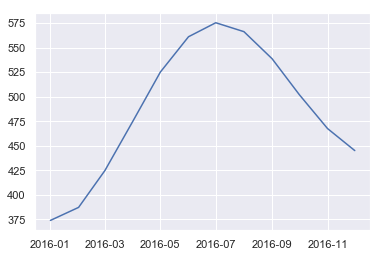

In [95]:
plt.plot(next_year)